<a href="https://www.kaggle.com/code/bencaiello/cve-dataset?scriptVersionId=141028773" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cve-common-vulnerabilities-and-exposures/products.csv
/kaggle/input/cve-common-vulnerabilities-and-exposures/vendors.csv
/kaggle/input/cve-common-vulnerabilities-and-exposures/cve.csv
/kaggle/input/cve-common-vulnerabilities-and-exposures/vendor_product.csv


# Initial Data examination, then Data Cleaning steps

Confirming relationships between the four data tables, merging of the tables, identification of duplicates, handling of null values, and work with datetime columns. 

Output is the .info() of the cleaned dataframe

In [2]:
import warnings

warnings.simplefilter('ignore')

#access files
file1 = pd.read_csv('/kaggle/input/cve-common-vulnerabilities-and-exposures/products.csv')
file2 = pd.read_csv('/kaggle/input/cve-common-vulnerabilities-and-exposures/vendors.csv')
file3 = pd.read_csv('/kaggle/input/cve-common-vulnerabilities-and-exposures/cve.csv')
file4 = pd.read_csv('/kaggle/input/cve-common-vulnerabilities-and-exposures/vendor_product.csv')

#see what's inside
'''
print('product: \n', file1.head(), len(file1))
print('\nvendors: \n', file2.head(), len(file2))
print('\ncve: \n',file3.head(), len(file3))
print('\nvendor_product: \n', file4.head(), len(file4))

#Look at nulls in the dataframe:
print('file1: \n',file1.info()) #some NaN's in vulnerable_product column -- some cv_ids not associated with any product
print('file2: \n',file2.info()) #some NaN's in vendor column -- some cv_ids not associated with any vendor (same # as missing for product)
print('file3: \n',file3.info()) # ~half of the columns are complete, ~1/2 are missing a small number of values [same # of values in each column]
print('file4: \n',file4.info()) #no null values

##Relationships between tables in the dataset:
#Main file about the cves of use seems to be file3:
    # file1 supplies connection between cve_id and product
    # file 2 supplies connection between cve_id and vendor
    # file 4 supplies conncetion between vendor and product
    
#Look at duplicate values:
lendupfile1 = len(file1[file1['cve_id'].duplicated()==True])
print(lendupfile1, '  ' , len(file1) - lendupfile1)
print('Number of identical, unique cve values shared in file1,file2 and file3 [all = 89660, the length of file3]')

#slightly more than half of the cve_ids are duplicated, indicating vulnerabilities that affect more than one product.
print(sum(file1['cve_id'].unique() == file3['Unnamed: 0'].unique()))

#perfect correspondance between unique cve_id's in file1 and cve_ids in file2 and file3

print(sum(file3['Unnamed: 0'].unique() == file2['Unnamed: 0'].unique()))

# but obviously the cve_id corresponds to more than one vendor / product for many of the cve_ids
print('count of vendor unique values in file 2 and 4')
print(len(file2['vendor'].unique()))
print(len(file4['vendor'].unique()))

print('count of product unique values in file 1 and 4')
print(len(file1['vulnerable_product'].unique()))
print(len(file4['product'].unique()))
'''


#now I will drop nulls in file3 as for each column they are in they are <5% of the values in those columns
file3 = file3.dropna()


## Merge files:
# May work with original file (file3, or a a merge of file 2/3) just to use less computation per calculation. But if things aren't slowed down too much, I won't bother.
file3 = file3.rename(columns={'Unnamed: 0':'cve_id'})
file2 = file2.rename(columns={'Unnamed: 0':'cve_id'})

#if we want to merge everything (file 4 is dispensable, I think) 
file13 = file1.merge(file3)
file123 = file13.merge(file2)

#file123.info()
#file123.head()


sum(file123.duplicated()) # equals zero, so no duplicates. To see, wrap in a print statement or run on its own by ctrl-shift-enter in the notebook

#Convert date columsnt to datetime
file123['mod_date'] = pd.to_datetime(file123['mod_date'])
file123['pub_date'] = pd.to_datetime(file123['pub_date'])

#just make the mod date a function of the publication date
file123['mod_date'] = file123['mod_date'] - file123['pub_date'] 

#only remaining nulls (after dropping the null columns in file 3 earlier) are in the vendor/product columns that would represent cve's without a value in that column
#if the product is missing, it can't be filled easily, but if the vendor is missing, it may be inferrable from the product
#the description may also provide info
#But first: take a look at the NaN rows--

#print(file123[file123['vulnerable_product'].isna()]) # uncomment to run

#all NaN products are also the NaN vendors
#let's look at summary
pd.options.display.max_colwidth=500
#print(file123[file123['vendor'].isna()]['summary'].head(n=1)) # uncomment to see output
#checked one of the summaries, the only indicative word of vendor or product was 'oVirt'
file123 = file123.dropna()
file123[file123['vulnerable_product'].str.contains('oVirt')]

#no oVirt in product list -- will simply drop NaNs, as has already been done and not try to salvage NaNs in vendor/product columns
print(file123.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241979 entries, 0 to 242003
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype          
---  ------                  --------------   -----          
 0   cve_id                  241979 non-null  object         
 1   vulnerable_product      241979 non-null  object         
 2   mod_date                241979 non-null  timedelta64[ns]
 3   pub_date                241979 non-null  datetime64[ns] 
 4   cvss                    241979 non-null  float64        
 5   cwe_code                241979 non-null  int64          
 6   cwe_name                241979 non-null  object         
 7   summary                 241979 non-null  object         
 8   access_authentication   241979 non-null  object         
 9   access_complexity       241979 non-null  object         
 10  access_vector           241979 non-null  object         
 11  impact_availability     241979 non-null  object         
 12  impact_confident

# Visualization: CVSS scores -- overall distribution


Now that nulls are gone, and the data relatively clean, we can start to look at it

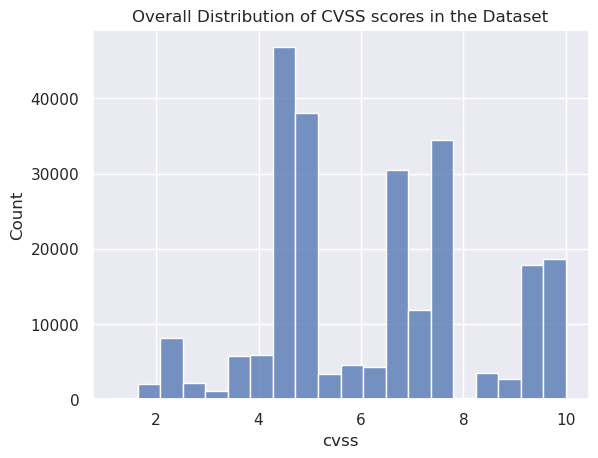

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

#looking at what a cvss score is: https://nvd.nist.gov/vuln-metrics/cvss. As it is a numerical way of scoring the severity of a threat, this is likely our main target metric (for most plots)
#CVSS is also almost the only numerical column in the dataset, except perhaps the mod_date, now that that column is a change in time from publication date.
#The other columns are all categorical or descriptive. This means I likely will mainly be using categorical plots / grouped data methods for visualization.
sns.histplot(data = file123, x ='cvss',bins=20)
plt.title("Overall Distribution of CVSS scores in the Dataset")
plt.show()


# Visualizations (cont.): most affected vendors

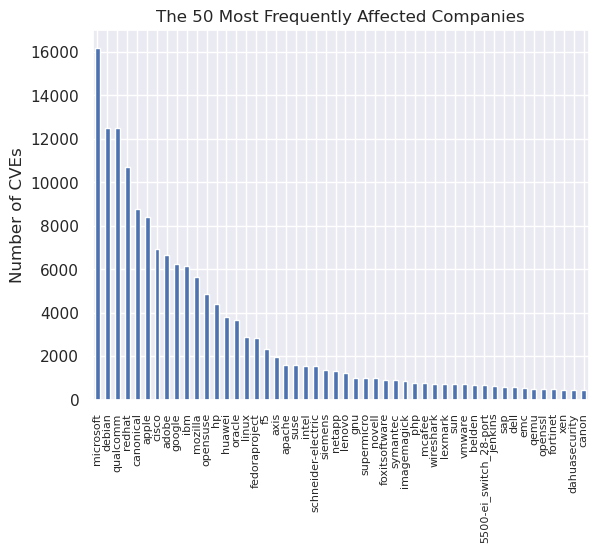

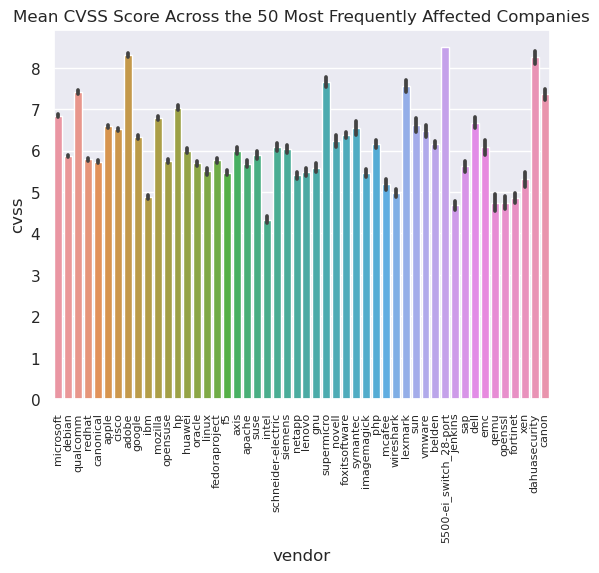

In [4]:
top_vend = file123['vendor'].value_counts().head(n=50)
top = list(top_vend.index)

top_vend.plot(kind='bar')
plt.title("The 50 Most Frequently Affected Companies")
plt.ylabel('Number of CVEs')
plt.xticks(rotation = 90,size=8)
plt.show()

file123_top = file123[file123['vendor'].isin(top)]
sns.barplot(x='vendor',y='cvss',data=file123_top,order=top)
plt.title("Mean CVSS Score Across the 50 Most Frequently Affected Companies")
plt.xticks(rotation = 90,size=8)
plt.show()

# Visualizations: Top Affected products

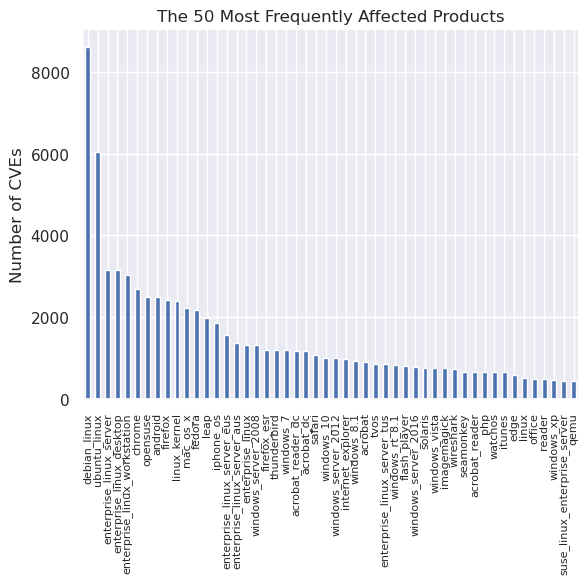

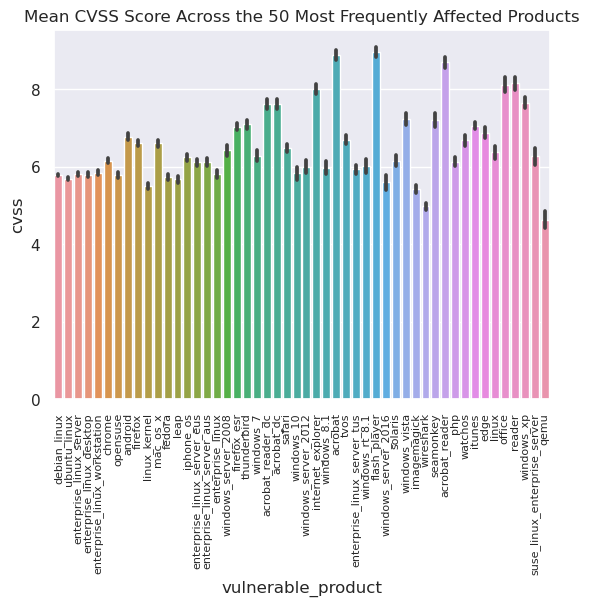

In [5]:
top_prod = file123['vulnerable_product'].value_counts().head(n=50)
top_p = list(top_prod.index)

top_prod.plot(kind='bar')
plt.title("The 50 Most Frequently Affected Products")
plt.ylabel('Number of CVEs')
plt.xticks(rotation = 90,size=8)
plt.show()

file123_top_p = file123[file123['vulnerable_product'].isin(top_p)]
sns.barplot(x='vulnerable_product',y='cvss',data=file123_top_p,order=top_p)
plt.title("Mean CVSS Score Across the 50 Most Frequently Affected Products")
plt.xticks(rotation = 90,size=8)
plt.show()

# Visualization: Operating systems

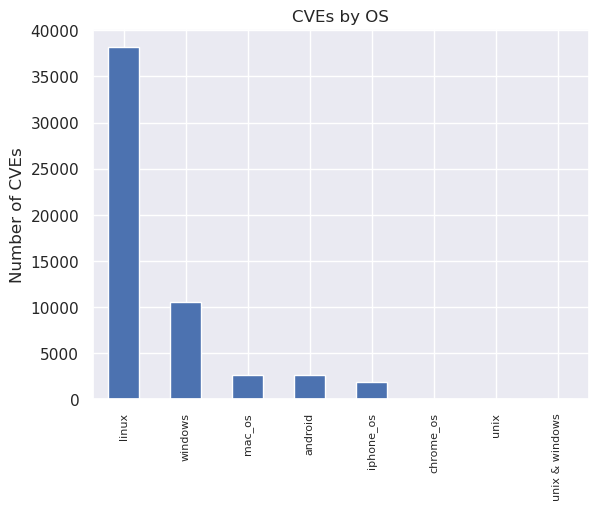

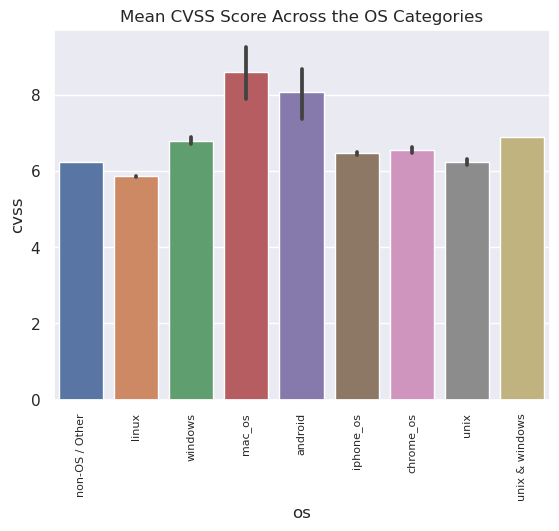

In [6]:
#In the product bar-charts above we can see a lot of "linux" or "windows" in the names
#let's see if we can extra information about the OS from the product name

file123['is_linux'] = np.where(file123['vulnerable_product'].str.lower().str.contains('linux'),1,0)
file123['is_android'] = np.where(file123['vulnerable_product'].str.lower().str.contains('android'),2,0)
file123['is_unix'] = np.where(file123['vulnerable_product'].str.lower().str.contains('unix'),3,0)
file123['is_chrome'] = np.where(file123['vulnerable_product'].str.lower().str.contains('chrome_os'),4,0)
file123['is_windows'] = np.where(file123['vulnerable_product'].str.lower().str.contains('windows'),5,0)
file123['is_mac'] = np.where(file123['vulnerable_product'].str.lower().str.contains('mac_os'),6,0)
file123['is_iphone'] = np.where(file123['vulnerable_product'].str.lower().str.contains('iphone_os'),7,0)

file123['os'] = file123['is_iphone'] + file123['is_linux'] + file123['is_mac'] + file123['is_android'] + file123['is_chrome'] + file123['is_windows'] + file123['is_unix']

#take a look inside 'mac' (as I have a choice of searching for 'mac' or 'mac_os'): (uncomment to run)
#print(file123[file123['vulnerable_product'].str.lower().str.contains('mac')])
#Top result is 'maconomy', simple google search reveals this has nothing to do with mac_os.... so 'mac_os' it is!


#compare counts of individual columns vs. combined result: one windows + unix (value = 8) product
#note this is after re-ordering columns and refining str.contains('statements'). 
#Of note, I added "_os" to the chrome search, which greatly reduced the number of hits for chrome (presumably excluding the browser)
#Importantly, this also reduced the number of overlapped values to 2 (using 'mac_os' instead of 'mac' reduces this to 1). 
'''#Uncomment code block to see test/comparison of the individual columns to the singular os column:
print(0)
print(sum(file123['is_linux']))
print(sum(file123['is_android'] / 2))
print(sum(file123['is_unix'] / 3))
print(sum(file123['is_chrome'] / 4))
print(sum(file123['is_windows'] / 5))
print(sum(file123['is_mac'] / 6))
print(sum(file123['is_iphone'] / 7))

print(file123['os'].value_counts().sort_index())
'''
#Now, let's plot:

labels_by_order=['linux','windows','mac_os','android','iphone_os','chrome_os','unix','unix & windows']
labels_by_order_with_non_os = ['non-OS / Other','linux','windows','mac_os','android','iphone_os','chrome_os','unix','unix & windows']
OS_count = file123['os'].value_counts()[1:]

OS_count.plot(kind='bar')
plt.title("CVEs by OS")
plt.ylabel('Number of CVEs')
plt.xticks(rotation = 90,size=8,ticks=[0,1,2,3,4,5,6,7],labels = labels_by_order)
plt.show()

sns.barplot(x='os',y='cvss',data=file123)
plt.title("Mean CVSS Score Across the OS Categories")
plt.xticks(rotation = 90,size=8,ticks=[0,1,2,3,4,5,6,7,8],labels = labels_by_order_with_non_os)
plt.show()

Perhaps this might have to do with the open-source nature of linux making its CVE's more frequently/easily reported? Linux has dramatically more CVE's in this dataset but the mean CVSS score is noticeably lower than the other common OS's.



Caveats: not all OS's are captured in this graph, and it is likely that my search terms may have excluded some as well (for example, 'mac_os' as a search term might miss some mac operating systems. It reduced the number of cve's in that search by ~1200 events, compared to only searching for 'mac'. However, I chose the more exclusive term to remove programs, like 'maconomy' that might show up in my results with a less stringent search)

# CVSS score across access methods and impact on different parts of the CIA triad


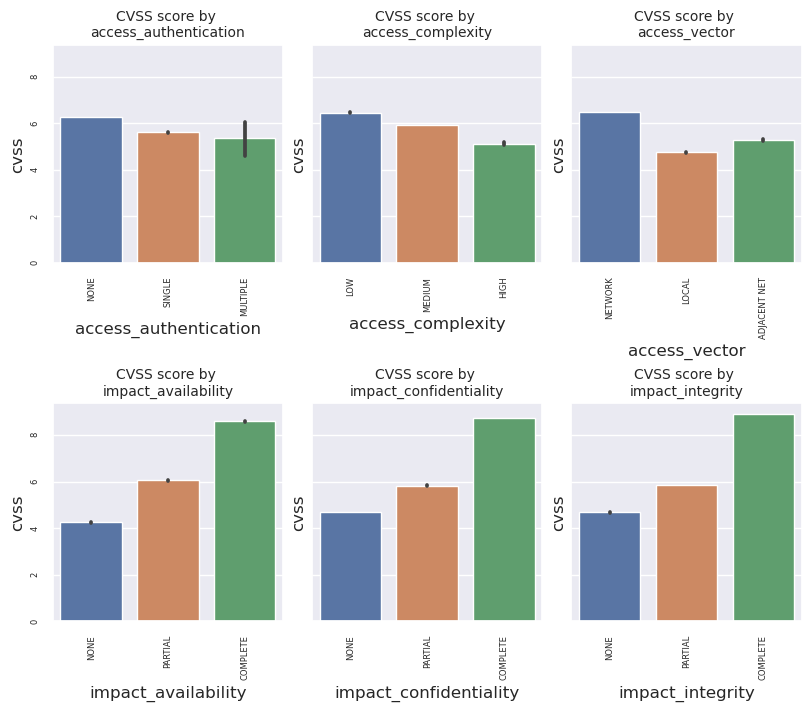

In [7]:
cols = file123.columns[8:14]
file123['access_vector'] = file123['access_vector'].str.replace('_NETWORK',' NET')

fig,ax = plt.subplots(nrows = 2,ncols=3,sharey=True,layout = 'constrained',figsize = (8,7))
i = 0
for axs in ax.flat:
    if i < 3:
        sns.barplot(x=cols[i],y='cvss',data=file123,ax=axs)
    else:
        sns.barplot(x=cols[i],y='cvss',data=file123,ax=axs,order=['NONE','PARTIAL','COMPLETE'])
    axs.set_title('CVSS score by \n{}'.format(cols[i]),size = 10)
    i += 1
    axs.tick_params(labelrotation=90,labelsize=6)
plt.show()

# Visualization of CVE's over time

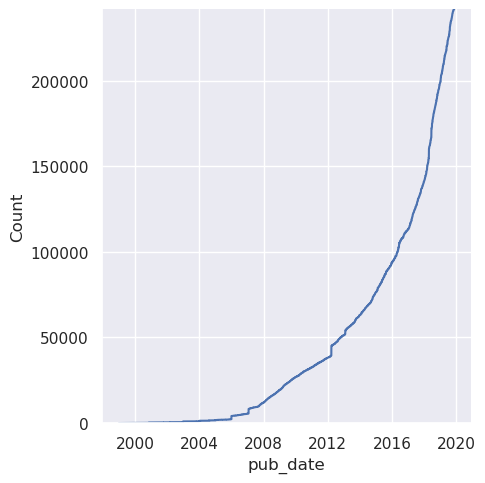

In [8]:
'''
cols = file123.columns[8:14]

for i in cols:
    print(i,'\n',file123[i].value_counts().index)
'''

sns.displot(file123, x = 'pub_date',kind = 'ecdf',stat='count')
plt.show()